In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from collections import Counter 
from tqdm import tqdm
from random import seed, randint, choice

from swarm_sim import *

%matplotlib inline 

In [75]:
# 1st dataset: N=50
PATH = '..\\..\\data\\swarm-50-sats-scenario\\coords_v1_if_LLO-'
EXPORT_PATH = 'output\\data'
ROW_DATA = 7

NB_NODES = 50
DURATION = 8641 # Number of data rows, not time!
REVOLUTION = 1800 # Number of data rows
CONNECTION_RANGE = 30 # km

SAMPLE_STEP = 12


In [3]:
satellites = {} # Dict(sat_id: DataFrame)
with tqdm(total=NB_NODES, desc='Extracting data') as pbar:
    for i in range(NB_NODES):
        df_data = pd.read_csv(PATH+str(i)+'.csv', skiprows= lambda x: x<ROW_DATA, header=0)
        satellites[i] = df_data
        pbar.update(1)
        
swarm_data = {} # Dict{timestamp: Swarm}
with tqdm(total=REVOLUTION, desc='Converting to topologies') as pbar:
    for t in range(REVOLUTION):
        swarm_data[t] = Swarm(CONNECTION_RANGE,
                    nodes = [Node(id, sat['xF[km]'].iloc[t], sat['yF[km]'].iloc[t], sat['zF[km]'].iloc[t]) for id,sat in satellites.items()]
                    )
        pbar.update(1)

neighbor_matrices = {} # Dict{timestamp: matrix}
with tqdm(total=REVOLUTION, desc='Computing neighbor matrices') as pbar:
    for t in range(REVOLUTION):
        neighbor_matrices[t] = swarm_data[t].neighbor_matrix()
        pbar.update(1)

topo_graphs = {} # Dict{timestamp: Graph}
with tqdm(total=REVOLUTION, desc='Converting to NetworkX graphs') as pbar:
    for t in range(REVOLUTION):
        topo_graphs[t] = swarm_data[t].swarm_to_nxgraph()
        pbar.update(1)

Converting to NetworkX graphs: 100%|██████████| 1800/1800 [00:03<00:00, 456.18it/s]


## Temporal evolution
Analysed metrics:
- Network size (NS)
- Average degree (AD): number of direct neighbor(s) for each node, averaged
- Graph density (GD): ratio of observed edges over maximum possible number of edges
- Average clustering coefficient (ACC): ratio of observed edges in the neighborhood over maximum possible number of edges, averaged
- Diameter (Dia): maximum shortest path length between all pairs of nodes

Implemented algorithms for comparison:
- Random Node Division (RND)
- Multiple Independent Random Walks (MIRW)
- Forest Fire Division (FFD)

In [16]:
graph = topo_graphs[0]

np.mean(list(nx.betweenness_centrality(graph).values()))
#

0.02261904761904762

In [144]:
# Reference temporal evolution: Average Degree, Graph Density, Average Clustering Coefficient
ref_ad, ref_acc, ref_bc = [], [], []

with tqdm(total=REVOLUTION/SAMPLE_STEP, desc='Reference metrics') as pbar:
    for t in np.arange(0, REVOLUTION, SAMPLE_STEP):
        graph = topo_graphs[t]
        ref_ad.append(np.mean(nx.degree(graph)))
        ref_acc.append(nx.average_clustering(graph))
        ref_bc.append(np.mean(list(nx.betweenness_centrality(graph).values())))
        pbar.update(1)

Reference metrics: 100%|██████████| 150/150.0 [00:01<00:00, 138.14it/s]


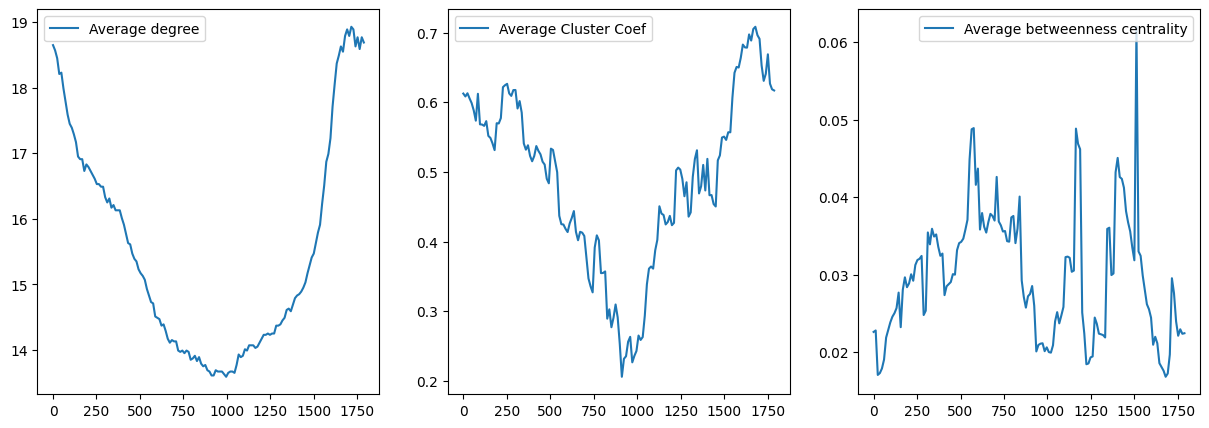

In [145]:
fig, axes = plt.subplots(ncols=3, figsize=(15,5))
idx = np.arange(0, REVOLUTION, SAMPLE_STEP)

ax = axes[0]
ax.plot(idx, ref_ad, label='Average degree')
ax.legend()

ax = axes[1]
ax.plot(idx, ref_acc, label='Average Cluster Coef')
ax.legend()

ax = axes[2]
ax.plot(idx, ref_bc, label='Average betweenness centrality')
ax.legend()

In [80]:
def variance(data, mean=None):
    if mean == None:
        mean = np.mean(data)
    return np.mean([(d - mean)**2 for d in data])

In [81]:
NB_GROUPS = 10
NB_REPETITIONS = 1

## 1. Random Node Division

In [82]:
swarm = swarm_data[0]
swarm.reset_groups()

groups = swarm.RND(n=NB_GROUPS, s=1, by_id=True) # <==================== ALGO CHOICE 

group_assignment = {}
for node in swarm.nodes:
    group_assignment[node.id] = node.group

In [146]:
var_dict = {
    'Timestamp':[],
    'Var_degree':[],
    'Var_cc':[],
    'Var_bc':[]
}

algo = 'RND' # <==================== ALGO CHOICE 
print('\nPerforming graph division:', algo, '\t\tNumber of repetitions:', NB_REPETITIONS)


for rep in range(NB_REPETITIONS):
    swarm_data[0].reset_groups()
    groups = swarm_data[0].RND(n=NB_GROUPS, s=rep+1, by_id=True)# <==================== ALGO CHOICE 

    with tqdm(total=REVOLUTION/SAMPLE_STEP, desc='Variance computation '+str(rep)) as pbar:
        for t in np.arange(0, REVOLUTION, SAMPLE_STEP):
            graph = topo_graphs[t]

            group_degree = [] # List(mean degree of group)
            group_cc = []
            group_bc = []

            for group_id, node_list in groups.items():
                if len(node_list)>0:
                    group_degree.append(np.mean(nx.degree(graph, node_list)))
                    group_cc.append(nx.average_clustering(graph, node_list))
                    bc_dict = nx.betweenness_centrality(graph)
                    group_bc.append(np.mean([bc_dict[i] for i in node_list]))
                
            var_degree = variance(group_degree, ref_ad[int(t/SAMPLE_STEP)]) 
            var_cc = variance(group_cc, ref_acc[int(t/SAMPLE_STEP)]) 
            var_bc = variance(group_bc, ref_bc[int(t/SAMPLE_STEP)]) 
            
            var_dict['Timestamp'].append(t)
            var_dict['Var_degree'].append(var_degree)
            var_dict['Var_cc'].append(var_cc)
            var_dict['Var_bc'].append(var_bc)
            
            pbar.update(1)


Performing graph division: RND 		Number of repetitions: 1


Variance computation 0: 100%|██████████| 150/150.0 [00:08<00:00, 18.34it/s]


In [147]:
df = pd.DataFrame(var_dict)
df.groupby('Timestamp').mean()

,Var_degree,Var_cc,Var_bc
Timestamp,,,
0,12.846090,0.003741,0.000085
12,12.493233,0.004435,0.000091
24,12.723618,0.009054,0.000038
36,13.466389,0.011027,0.000029
48,13.104107,0.011549,0.000074
...,...,...,...
1740,11.260713,0.004109,0.000082
1752,10.598947,0.003959,0.000099
1764,10.505892,0.002985,0.000068


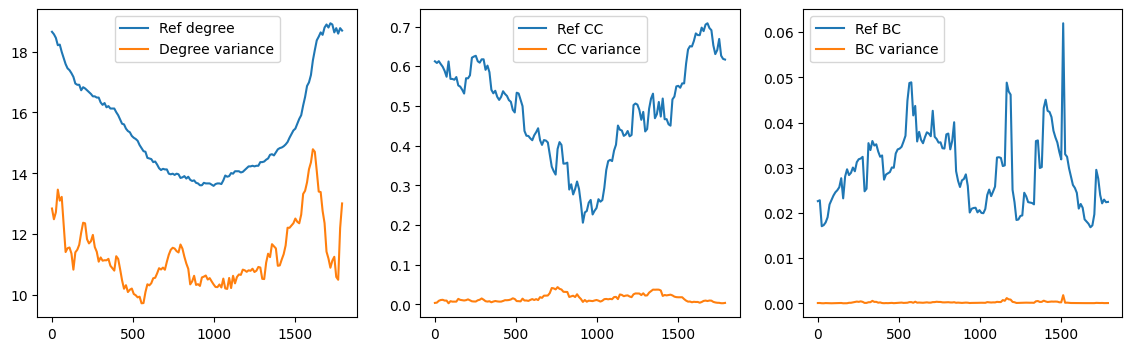

In [152]:
fig, axes = plt.subplots(figsize=(14,4), ncols=3)

ax = axes[0]
ax.plot(idx, ref_ad, label='Ref degree')
ax.plot(idx, df['Var_degree'], label='Degree variance')
ax.legend()

ax = axes[1]
ax.plot(idx, ref_acc, label='Ref CC')
ax.plot(idx, df['Var_cc'], label='CC variance')
ax.legend()

ax = axes[2]
ax.plot(idx, ref_bc, label='Ref BC')
ax.plot(idx, df['Var_bc'], label='BC variance')
ax.legend()

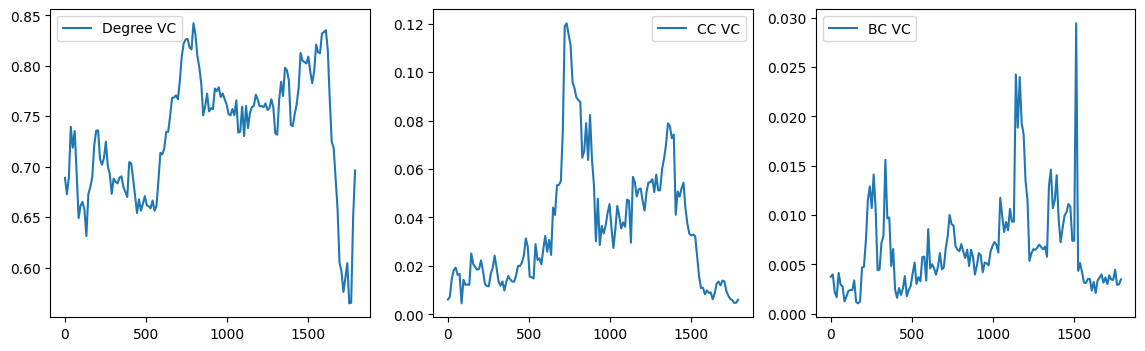

In [164]:
fi_degree = [var/ref for var,ref in zip(df['Var_degree'].tolist(), ref_ad)]
fi_cc = [var/ref for var,ref in zip(df['Var_cc'].tolist(), ref_acc)]
fi_bc = [var/ref for var,ref in zip(df['Var_bc'].tolist(), ref_bc)]

fig, axes = plt.subplots(figsize=(14,4), ncols=3)

ax = axes[0]
ax.plot(idx, fi_degree, label='Degree VC')
ax.legend()

ax = axes[1]
ax.plot(idx, fi_cc, label='CC VC')
ax.legend()

ax = axes[2]
ax.plot(idx, fi_bc, label='BC VC')
ax.legend()